# XMM-LSS master catalogue

This notebook presents the merge of the various pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
#candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))           # 1.1
#cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
#cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
#cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
#decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6
#servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
#swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7
hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
#ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
#sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
#sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
#dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
#uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
#vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
#vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
#video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
#viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Start with HSC-WIDE

In [5]:
master_catalogue = hsc_wide
master_catalogue['hsc-wide_ra'].name = 'ra'
master_catalogue['hsc-wide_dec'].name = 'dec'

### Add HSC-DEEP

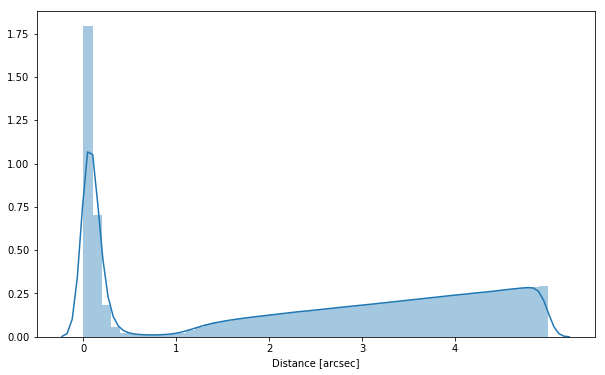

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_deep['hsc-deep_ra'], hsc_deep['hsc-deep_dec'])
)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc_deep, "hsc-deep_ra", "hsc-deep_dec", radius=0.8*u.arcsec)


### Add HSC-UDEEP

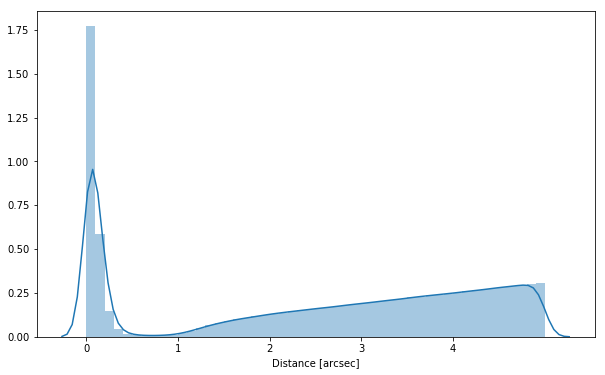

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_udeep['hsc-udeep_ra'], hsc_udeep['hsc-udeep_dec'])
)

In [9]:
master_catalogue = merge_catalogues(master_catalogue, hsc_udeep, "hsc-udeep_ra", "hsc-udeep_dec", radius=0.8*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [10]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [11]:
#Since this is not the final merged catalogue. We rename column names to make them unique
master_catalogue['ra'].name = 'hsc_ra'
master_catalogue['dec'].name = 'hsc_dec'
master_catalogue['flag_merged'].name = 'hsc_flag_merged'

In [12]:
master_catalogue[:10].show_in_notebook()

idx,hsc-wide_id,hsc_ra,hsc_dec,m_ap_hsc-wide_g,merr_ap_hsc-wide_g,m_hsc-wide_g,merr_hsc-wide_g,m_ap_hsc-wide_r,merr_ap_hsc-wide_r,m_hsc-wide_r,merr_hsc-wide_r,m_ap_hsc-wide_i,merr_ap_hsc-wide_i,m_hsc-wide_i,merr_hsc-wide_i,m_ap_hsc-wide_z,merr_ap_hsc-wide_z,m_hsc-wide_z,merr_hsc-wide_z,m_ap_hsc-wide_y,merr_ap_hsc-wide_y,m_hsc-wide_y,merr_hsc-wide_y,hsc-wide_stellarity,f_ap_hsc-wide_g,ferr_ap_hsc-wide_g,f_hsc-wide_g,ferr_hsc-wide_g,flag_hsc-wide_g,f_ap_hsc-wide_r,ferr_ap_hsc-wide_r,f_hsc-wide_r,ferr_hsc-wide_r,flag_hsc-wide_r,f_ap_hsc-wide_i,ferr_ap_hsc-wide_i,f_hsc-wide_i,ferr_hsc-wide_i,flag_hsc-wide_i,f_ap_hsc-wide_z,ferr_ap_hsc-wide_z,f_hsc-wide_z,ferr_hsc-wide_z,flag_hsc-wide_z,f_ap_hsc-wide_y,ferr_ap_hsc-wide_y,f_hsc-wide_y,ferr_hsc-wide_y,flag_hsc-wide_y,hsc-wide_flag_cleaned,hsc-wide_flag_gaia,hsc_flag_merged,hsc-deep_id,m_ap_hsc-deep_g,merr_ap_hsc-deep_g,m_hsc-deep_g,merr_hsc-deep_g,m_ap_hsc-deep_r,merr_ap_hsc-deep_r,m_hsc-deep_r,merr_hsc-deep_r,m_ap_hsc-deep_i,merr_ap_hsc-deep_i,m_hsc-deep_i,merr_hsc-deep_i,m_ap_hsc-deep_z,merr_ap_hsc-deep_z,m_hsc-deep_z,merr_hsc-deep_z,m_ap_hsc-deep_y,merr_ap_hsc-deep_y,m_hsc-deep_y,merr_hsc-deep_y,hsc-deep_stellarity,f_ap_hsc-deep_g,ferr_ap_hsc-deep_g,f_hsc-deep_g,ferr_hsc-deep_g,flag_hsc-deep_g,f_ap_hsc-deep_r,ferr_ap_hsc-deep_r,f_hsc-deep_r,ferr_hsc-deep_r,flag_hsc-deep_r,f_ap_hsc-deep_i,ferr_ap_hsc-deep_i,f_hsc-deep_i,ferr_hsc-deep_i,flag_hsc-deep_i,f_ap_hsc-deep_z,ferr_ap_hsc-deep_z,f_hsc-deep_z,ferr_hsc-deep_z,flag_hsc-deep_z,f_ap_hsc-deep_y,ferr_ap_hsc-deep_y,f_hsc-deep_y,ferr_hsc-deep_y,flag_hsc-deep_y,hsc-deep_flag_cleaned,hsc-deep_flag_gaia,hsc-udeep_id,m_ap_hsc-udeep_g,merr_ap_hsc-udeep_g,m_hsc-udeep_g,merr_hsc-udeep_g,m_ap_hsc-udeep_r,merr_ap_hsc-udeep_r,m_hsc-udeep_r,merr_hsc-udeep_r,m_ap_hsc-udeep_i,merr_ap_hsc-udeep_i,m_hsc-udeep_i,merr_hsc-udeep_i,m_ap_hsc-udeep_z,merr_ap_hsc-udeep_z,m_hsc-udeep_z,merr_hsc-udeep_z,m_ap_hsc-udeep_y,merr_ap_hsc-udeep_y,m_hsc-udeep_y,merr_hsc-udeep_y,m_ap_hsc-udeep_n921,merr_ap_hsc-udeep_n921,m_hsc-udeep_n921,merr_hsc-udeep_n921,m_ap_hsc-udeep_n816,merr_ap_hsc-udeep_n816,m_hsc-udeep_n816,merr_hsc-udeep_n816,hsc-udeep_stellarity,f_ap_hsc-udeep_g,ferr_ap_hsc-udeep_g,f_hsc-udeep_g,ferr_hsc-udeep_g,flag_hsc-udeep_g,f_ap_hsc-udeep_r,ferr_ap_hsc-udeep_r,f_hsc-udeep_r,ferr_hsc-udeep_r,flag_hsc-udeep_r,f_ap_hsc-udeep_i,ferr_ap_hsc-udeep_i,f_hsc-udeep_i,ferr_hsc-udeep_i,flag_hsc-udeep_i,f_ap_hsc-udeep_z,ferr_ap_hsc-udeep_z,f_hsc-udeep_z,ferr_hsc-udeep_z,flag_hsc-udeep_z,f_ap_hsc-udeep_y,ferr_ap_hsc-udeep_y,f_hsc-udeep_y,ferr_hsc-udeep_y,flag_hsc-udeep_y,f_ap_hsc-udeep_n921,ferr_ap_hsc-udeep_n921,f_hsc-udeep_n921,ferr_hsc-udeep_n921,flag_hsc-udeep_n921,f_ap_hsc-udeep_n816,ferr_ap_hsc-udeep_n816,f_hsc-udeep_n816,ferr_hsc-udeep_n816,flag_hsc-udeep_n816,hsc-udeep_flag_cleaned,hsc-udeep_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,37490060857200559,34.9726111128,-5.4166039686,18.1954231262,0.000348298170138,16.9402427673,0.000239045388298,17.3080711365,0.000247762305662,16.0773925781,0.000173026288394,16.8611335754,0.000145619880641,15.6328935623,0.000109840199002,16.5656242371,0.000199918460567,15.3488559723,0.000171216175659,16.3776283264,0.000275221042102,15.1513872147,0.00028448345256,0.0,191.350921631,0.0613843128085,607.998718262,0.133862435818,False,433.282775879,0.0988740622997,1345.99328613,0.214501649141,False,653.952941895,0.0877087339759,2026.94677734,0.205059230328,False,858.519470215,0.158080652356,2633.03930664,0.415219575167,False,1020.81860352,0.25876519084,3158.23876953,0.827518343925,False,False,3,False,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,False,0,-1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan

In [13]:
master_catalogue.add_column(Column(data=(np.char.array(master_catalogue['hsc-wide_id'].astype(str)) 
                                    +  np.char.array(master_catalogue['hsc-deep_id'].astype(str) )
                                    +  np.char.array(master_catalogue['hsc-udeep_id'].astype(str))), 
                              name="hsc_intid"))

In [14]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['hsc-wide_id', 'hsc-deep_id', 'hsc-udeep_id', 'hsc_intid']


## VII - Choosing between multiple values for the same filter



### VII. e HSC wide, deep and udeep
Here we straightforwardly take the deepest

| Survey      | Bands observed   |
|-------------|------------------|
| HSC-WIDE    | grizy            |
| HSC-DEEP    | grizy            |
| HSC-UDEEP   | grizy n921 n816  |

In [15]:
suprime_origin = Table()
suprime_origin.add_column(master_catalogue['hsc_intid'])

In [16]:
suprime_stats = Table()
suprime_stats.add_column(Column(data=['g','r','i','z','y'], name="Band"))
for col in ["HSC-UDEEP",  "HSC-DEEP", "HSC-WIDE"]:
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{} ap".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {} ap".format(col)))
    
#n921 and n816 only in udeep so we can just rename those columns
for col in master_catalogue.colnames:
    if ('n921' in col) or ('n816' in col):
        master_catalogue[col].name = col.replace('hsc-udeep', 'suprime')

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(5, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [17]:
suprime_bands = ['g','r','i','z','y'] # Lowercase naming convention (k is Ks)
for band in suprime_bands:

    # Suprime total flux 
    has_hsc_udeep = ~np.isnan(master_catalogue['f_hsc-udeep_' + band])
    has_hsc_deep  = ~np.isnan(master_catalogue['f_hsc-deep_' + band])
    has_hsc_wide  = ~np.isnan(master_catalogue['f_hsc-wide_' + band])
    

    use_hsc_udeep = has_hsc_udeep
    use_hsc_deep = has_hsc_deep & ~has_hsc_udeep
    use_hsc_wide = has_hsc_wide & ~has_hsc_deep & ~has_hsc_udeep

    f_suprime = np.full(len(master_catalogue), np.nan)
    f_suprime[use_hsc_udeep] = master_catalogue['f_hsc-udeep_' + band][use_hsc_udeep]
    f_suprime[use_hsc_deep] = master_catalogue['f_hsc-deep_' + band][use_hsc_deep]
    f_suprime[use_hsc_wide] = master_catalogue['f_hsc-wide_' + band][use_hsc_wide]

    ferr_suprime = np.full(len(master_catalogue), np.nan)
    ferr_suprime[use_hsc_udeep] = master_catalogue['ferr_hsc-udeep_' + band][use_hsc_udeep]
    ferr_suprime[use_hsc_deep] = master_catalogue['ferr_hsc-deep_' + band][use_hsc_deep]
    ferr_suprime[use_hsc_wide] = master_catalogue['ferr_hsc-wide_' + band][use_hsc_wide]
    
    m_suprime = np.full(len(master_catalogue), np.nan)
    m_suprime[use_hsc_udeep] = master_catalogue['m_hsc-udeep_' + band][use_hsc_udeep]
    m_suprime[use_hsc_deep] = master_catalogue['m_hsc-deep_' + band][use_hsc_deep]
    m_suprime[use_hsc_wide] = master_catalogue['m_hsc-wide_' + band][use_hsc_wide]

    merr_suprime = np.full(len(master_catalogue), np.nan)
    merr_suprime[use_hsc_udeep] = master_catalogue['merr_hsc-udeep_' + band][use_hsc_udeep]
    merr_suprime[use_hsc_deep] = master_catalogue['merr_hsc-deep_' + band][use_hsc_deep]
    merr_suprime[use_hsc_wide] = master_catalogue['merr_hsc-wide_' + band][use_hsc_wide]

    flag_suprime = np.full(len(master_catalogue), False, dtype=bool)
    flag_suprime[use_hsc_udeep] = master_catalogue['flag_hsc-udeep_' + band][use_hsc_udeep]
    flag_suprime[use_hsc_deep] = master_catalogue['flag_hsc-deep_' + band][use_hsc_deep]
    flag_suprime[use_hsc_wide] = master_catalogue['flag_hsc-wide_' + band][use_hsc_wide]

    master_catalogue.add_column(Column(data=f_suprime, name="f_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_suprime, name="ferr_suprime_" + band))
    master_catalogue.add_column(Column(data=m_suprime, name="m_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_suprime, name="merr_suprime_" + band))
    master_catalogue.add_column(Column(data=flag_suprime, name="flag_suprime_" + band))

    old_hsc_udeep_columns = ['f_hsc-udeep_' + band,
                               'ferr_hsc-udeep_' + band,
                               'm_hsc-udeep_' + band, 
                               'merr_hsc-udeep_' + band,
                               'flag_hsc-udeep_' + band]
    old_hsc_deep_columns = ['f_hsc-deep_' + band,
                               'ferr_hsc-deep_' + band,
                               'm_hsc-deep_' + band, 
                               'merr_hsc-deep_' + band,
                               'flag_hsc-deep_' + band]
    old_hsc_wide_columns =      ['f_hsc-wide_' + band,
                               'ferr_hsc-wide_' + band,
                               'm_hsc-wide_' + band, 
                               'merr_hsc-wide_' + band,
                               'flag_hsc-wide_' + band]
    
    old_columns = old_hsc_udeep_columns + old_hsc_deep_columns + old_hsc_wide_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_hsc_udeep] = "HSC-UDEEP"
    origin[use_hsc_deep] = "HSC-DEEP"
    origin[use_hsc_wide] = "HSC-WIDE"
    
    suprime_origin.add_column(Column(data=origin, name= 'f_suprime_' + band ))
    
  
    # Suprime aperture flux 
    has_ap_hsc_udeep = ~np.isnan(master_catalogue['f_ap_hsc-udeep_' + band])
    has_ap_hsc_deep  = ~np.isnan(master_catalogue['f_ap_hsc-deep_' + band])
    has_ap_hsc_wide  = ~np.isnan(master_catalogue['f_ap_hsc-wide_' + band])
    

    use_ap_hsc_udeep = has_ap_hsc_udeep
    use_ap_hsc_deep = has_ap_hsc_deep & ~has_ap_hsc_udeep
    use_ap_hsc_wide = has_ap_hsc_wide & ~has_ap_hsc_deep & ~has_ap_hsc_udeep

    f_ap_suprime = np.full(len(master_catalogue), np.nan)
    f_ap_suprime[use_ap_hsc_udeep] = master_catalogue['f_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    f_ap_suprime[use_ap_hsc_deep] = master_catalogue['f_ap_hsc-deep_' + band][use_ap_hsc_deep]
    f_ap_suprime[use_ap_hsc_wide] = master_catalogue['f_ap_hsc-wide_' + band][use_ap_hsc_wide]

    ferr_ap_suprime = np.full(len(master_catalogue), np.nan)
    ferr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['ferr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    ferr_ap_suprime[use_ap_hsc_deep] = master_catalogue['ferr_ap_hsc-deep_' + band][use_ap_hsc_deep]
    ferr_ap_suprime[use_ap_hsc_wide] = master_catalogue['ferr_ap_hsc-wide_' + band][use_ap_hsc_wide]
    
    m_ap_suprime = np.full(len(master_catalogue), np.nan)
    m_ap_suprime[use_ap_hsc_udeep] = master_catalogue['m_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    m_ap_suprime[use_ap_hsc_deep] = master_catalogue['m_ap_hsc-deep_' + band][use_ap_hsc_deep]
    m_ap_suprime[use_ap_hsc_wide] = master_catalogue['m_ap_hsc-wide_' + band][use_ap_hsc_wide]

    merr_ap_suprime = np.full(len(master_catalogue), np.nan)
    merr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['merr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    merr_ap_suprime[use_ap_hsc_deep] = master_catalogue['merr_ap_hsc-deep_' + band][use_ap_hsc_deep]
    merr_ap_suprime[use_ap_hsc_wide] = master_catalogue['merr_ap_hsc-wide_' + band][use_ap_hsc_wide]


    master_catalogue.add_column(Column(data=f_ap_suprime, name="f_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_suprime, name="ferr_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=m_ap_suprime, name="m_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_ap_suprime, name="merr_ap_suprime_" + band))


    old_ap_hsc_udeep_columns = ['f_ap_hsc-udeep_' + band,
                               'ferr_ap_hsc-udeep_' + band,
                               'm_ap_hsc-udeep_' + band, 
                               'merr_ap_hsc-udeep_' + band]
    old_ap_hsc_deep_columns = ['f_ap_hsc-deep_' + band,
                               'ferr_ap_hsc-deep_' + band,
                               'm_ap_hsc-deep_' + band, 
                               'merr_ap_hsc-deep_' + band]
    old_ap_hsc_wide_columns =      ['f_ap_hsc-wide_' + band,
                               'ferr_ap_hsc-wide_' + band,
                               'm_ap_hsc-wide_' + band, 
                               'merr_ap_hsc-wide_' + band]
    
    old_ap_columns = old_ap_hsc_udeep_columns + old_ap_hsc_deep_columns + old_ap_hsc_wide_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_hsc_udeep] = "HSC-UDEEP"
    origin_ap[use_ap_hsc_deep] = "HSC-DEEP"
    origin_ap[use_ap_hsc_wide] = "HSC-WIDE"
    
    suprime_origin.add_column(Column(data=origin_ap, name= 'f_ap_suprime_' + band ))

   
    suprime_stats['HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_udeep)
    suprime_stats['HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_deep)
    suprime_stats['HSC-WIDE'][suprime_stats['Band'] == band] = np.sum(has_hsc_wide)
    suprime_stats['use HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_udeep)
    suprime_stats['use HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_deep)
    suprime_stats['use HSC-WIDE'][suprime_stats['Band'] == band] = np.sum(use_hsc_wide)
    suprime_stats['HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_udeep)
    suprime_stats['HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_deep)
    suprime_stats['HSC-WIDE ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_wide)
    suprime_stats['use HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_udeep)
    suprime_stats['use HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_deep)
    suprime_stats['use HSC-WIDE ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_wide)

In [18]:
suprime_stats.show_in_notebook()

idx,Band,HSC-UDEEP,use HSC-UDEEP,HSC-UDEEP ap,use HSC-UDEEP ap,HSC-DEEP,use HSC-DEEP,HSC-DEEP ap,use HSC-DEEP ap,HSC-WIDE,use HSC-WIDE,HSC-WIDE ap,use HSC-WIDE ap
0,g,998673.0,998673.0,1095018.0,1095018.0,1919139.0,1772037.0,2174733.0,2000686.0,3829925.0,1960251.0,4307858.0,2092471.0
1,r,1000644.0,1000644.0,1108590.0,1108590.0,1917464.0,1773982.0,2205170.0,2032086.0,3818027.0,1965600.0,4341941.0,2102626.0
2,i,1005311.0,1005311.0,1121186.0,1121186.0,1882446.0,1738286.0,2147614.0,1973255.0,3878046.0,2016292.0,4412774.0,2162473.0
3,z,951892.0,951892.0,1080498.0,1080498.0,1755293.0,1629563.0,2007279.0,1854794.0,3684114.0,1956526.0,4278480.0,2140701.0
4,y,894655.0,894655.0,1022098.0,1022098.0,1613267.0,1491772.0,1889370.0,1734977.0,3353727.0,1840796.0,3929006.0,2011078.0


In [19]:
suprime_origin.write("{}/xmm-lss_hsc_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## XI - Saving the catalogue

In [20]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", 
            "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [21]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'hsc-wide_flag_cleaned', 'hsc-udeep_flag_cleaned', 'hsc-udeep_flag_gaia', 'hsc-wide_id', 'hsc_intid', 'hsc-deep_stellarity', 'hsc-deep_flag_gaia', 'hsc_dec', 'hsc_flag_merged', 'hsc-wide_stellarity', 'hsc-wide_flag_gaia', 'hsc-udeep_id', 'hsc-deep_id', 'hsc_ra', 'hsc-udeep_stellarity', 'hsc-deep_flag_cleaned'}


In [22]:
master_catalogue.write("{}/hsc_merged_catalogue_xmm-lss.fits".format(TMP_DIR), overwrite=True)